In [50]:
import os
import pandas as pd
def write_fasta(input_dict):
    with open(input_dict['save_path'], 'w') as f:
        f.write('>' + input_dict['title'] + '\n')
        f.write(input_dict['sequence'] + '\n')

def mutate_sequence(original_sequence, mutation_label, correction):
    standard_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    running_sequence = original_sequence
    for label in mutation_label:
        label = label.upper().strip()
        res1, pos, res2 = label[0], int(label[1:-1]), label[-1]
        pos = pos + correction
        # Check if res1 and res2 are standard amino acids
        if res1 not in standard_amino_acids or res2 not in standard_amino_acids:
            raise ValueError('res1 and res2 should be standard amino acids.')
        if original_sequence[pos-1] != res1:
            raise ValueError('The residue at position does not match res1.')
        running_sequence = running_sequence[:pos-1] + res2 + running_sequence[pos:]
    return running_sequence

def truncate_sequence(original_sequence, label): # label = 'start-end'
    if label is None:
        return original_sequence
    start, end = label.split('-')
    if end == 'end':
        end = len(original_sequence)
    elif start == 'start':
        start = 1
    start, end = int(start), int(end)
    truncated_sequence = original_sequence[start-1:end]
    return truncated_sequence

def generate_config(config_dict):
    """
    Generates a configuration string from a given dictionary input.

    Args:
    config_dict (dict): A dictionary containing the configuration data.

    Returns:
    str: A string representing the configuration in the specified format.
    """
    config_str = "defaults:\n  - base\n\n"
    config_str += f"job_name: \"{config_dict['job_name']}\"\n"
    
    for input_type in ['protein_inputs', 'na_inputs', 'sm_inputs']:
        if input_type in config_dict:
            config_str += f"{input_type}:\n"
            for key, value in config_dict[input_type].items():
                if input_type == 'sm_inputs' or input_type == 'na_inputs':
                    config_str += f"  {key}:\n    input: {value['input']}\n    input_type: \"{value['input_type']}\"\n"
                else:  # protein_inputs or na_inputs
                    config_str += f"  {key}:\n    fasta_file: {value['fasta_file']}\n"
    
    return config_str

In [4]:
# load the data
import pandas as pd

work_fpath = '/home/lwang/models/HDX_LSTM/data/Latest_set/merged_data-NAcomplex.xlsx'
work_df = pd.read_excel(work_fpath, sheet_name='Sheet1')
print(work_df.columns)
df1 = work_df.dropna(subset=['structure_file']).drop_duplicates(subset=['structure_file'])
df2 = work_df.dropna(subset=['structure_file']).drop_duplicates(subset=['protein', 'state'])
print(df1.shape)
print(df2.shape)

Index(['database_id', 'database', 'literature', 'protein', 'state',
       'match_uni', 'complex_uni', 'uni_sequence', 'modification', 'mutation',
       'truncation', 'complex_state', 'D_Conc', 'pH', 'temp', 'data_type',
       'check', 'structure_file', 'note', 'chain_identifier',
       'correction_value', 'protein_chain', 'NA_chain', 'SM_chain'],
      dtype='object')
(154, 24)
(213, 24)


In [10]:
import os
import pandas as pd

HDX_dir = f'/home/lwang/models/HDX_LSTM/data/Latest_set/HDX_files'
groups = work_df.dropna(subset=['structure_file']).groupby(['database_id'])

count = 0
for id, group in groups:
    group['label'] = group['protein']+group['state']
    labels = group['label'].unique()
    fname = id[0]
    fpath = f'{HDX_dir}/{fname}_revised.xlsx'
    if not os.path.exists(fpath):
        print(fpath)
        continue
    hdx_df = pd.read_excel(fpath, sheet_name='Sheet1')
    hdx_df['label'] = hdx_df['protein']+hdx_df['state']

    count += hdx_df[hdx_df['label'].isin(labels)].groupby(['label', 'sequence']).ngroups
print(count)


/home/lwang/models/HDX_LSTM/data/Latest_set/HDX_files/PXD041774_revised.xlsx
21799


In [ ]:
'''
FOR SINGLE CHAIN PROTEIN
'''
# output fasta files
fail_dict = {}
for index, row in work_df.iterrows():
    # create a dictionary to store the information
    database_id = row['database_id'].replace(' ', '')
    protein_id = row['protein'].replace(' ', '')
    state = row['state'].replace(' ', '')
    chain = 'A'
    correction = int(row['correction_value'])
    original_sequence = row['uni_sequence'].strip()
    current_label = database_id + '_' + protein_id + '_' + state + '_' + chain
    if os.path.isfile(os.path.join('/home/lwang/models/HDX_LSTM/data/Fullset/fasta_files/protein', f'{current_label}.fasta')):
        continue

    mutation_label = str(row['mutation']).strip().split('/')
    #print(f'mutation_label: {mutation_label}')
    truncation_label = str(row['truncation']).strip()
    print(f'current_label: {current_label}')
    modified_sequence = original_sequence

    if 'nan' not in mutation_label:
        modified_sequence = mutate_sequence(original_sequence, mutation_label,0)        
    if truncation_label != 'nan':
        modified_sequence = truncate_sequence(modified_sequence, truncation_label)
    fasta_dict = {
        'title': current_label,
        'sequence': modified_sequence,
        'save_path': os.path.join('/home/lwang/models/HDX_LSTM/data/Fullset/fasta_files/protein', f'{current_label}.fasta')
    }
    write_fasta(fasta_dict)
print(fail_dict)

In [ ]:
# generate config files
for fasta_file in os.listdir('/home/lwang/models/HDX_LSTM/data/Fullset/fasta_files/protein'):
    if fasta_file.endswith('.fasta'):
        parts = fasta_file.split('_')
        pdb_fname = '_'.join(parts[:-1])
        print(f'pdb_fname: {pdb_fname}')
        config_dict = {
            'job_name': pdb_fname,
            'protein_inputs': {
                'A': {
                    'fasta_file': f'/home/lwang/models/HDX_LSTM/data/Fullset/fasta_files/protein/{fasta_file}'
                }
            }
        }
        config_str = generate_config(config_dict)
        with open(f'/home/lwang/models/HDX_LSTM/data/Fullset/fasta_files/config/{pdb_fname}.yaml', 'w') as f:
            f.write(config_str)

In [127]:
'''
FOR COMPLEX
'''
# load the data
work_fpath = '/home/lwang/models/HDX_LSTM/data/Fullset/merged_data.xlsx'
work_df = pd.read_excel(work_fpath, sheet_name='Sheet1')

work_df = work_df[work_df['check'] != 'yes']
work_df = work_df[work_df['complex_state'] == 'protein complex']

print(work_df.shape)

for index, row in work_df.iterrows():
    # create a dictionary to store the information
    database_id = row['database_id'].replace(' ', '')
    protein_id = row['protein'].replace(' ', '')
    state = row['state'].replace(' ', '')
    chain = 'A'
    original_sequence = row['uni_sequence'].strip()
    current_label = database_id + '_' + protein_id + '_' + state + '_' + chain
    if os.path.isfile(os.path.join('/home/lwang/models/HDX_LSTM/data/Fullset/fasta_files/protein', f'{current_label}.fasta')):
        continue

    mutation_label = str(row['mutation']).strip().split('/')
    #print(f'mutation_label: {mutation_label}')
    truncation_label = str(row['truncation']).strip()
    print(f'current_label: {current_label}')
    modified_sequence = original_sequence

    if 'nan' not in mutation_label:
        modified_sequence = mutate_sequence(original_sequence, mutation_label,0)        
    if truncation_label != 'nan':
        modified_sequence = truncate_sequence(modified_sequence, truncation_label)
    fasta_dict = {
        'title': current_label,
        'sequence': modified_sequence,
        'save_path': os.path.join('/home/lwang/models/HDX_LSTM/data/Fullset/fasta_files/protein', f'{current_label}.fasta')
    }
    write_fasta(fasta_dict)
    break


(78, 23)
current_label: PXD019367_GoA_alpha_Alone_A


In [125]:
# write other chains
chain = 'C'
current_label = database_id + '_' + protein_id + '_' + state + '_' + chain
seq = 'MGCTLSAEERAALERSKAIEKNLKEDGISAAKDVKLLLLGAGESGKSTIVKQMKIIHEDGFSGEDVKQYKPVVYSNTIQSLAAIVRAMDTLGIEYGDKERKADAKMVCDVVSRMEDTEPFSAELLSAMMRLWGDSGIQECFNRSREYQLNDSAKYYLDSLDRIGAADYQPTEQDILRTRVKTTGIVETHFTFKNLHFRLFDVGGQRSERKKWIHCFEDVTAIIFCVALSGYDQVLHEDETTNRMHESLMLFDSICNNKFFIDTSIILFLNKKDLFGEKIKKSPLTICFPEYTGPNTYEDAAAYIQAQFESKNRSPNKEIYCHMTCATDTNNIQVVFDAVTDIIIANNLRGCGLY'
#seq = truncate_sequence(seq, '135-467')
print(f'current_label: {current_label}')
fasta_dict = {
    'title': current_label,
    'sequence': seq,
    'save_path': os.path.join('/home/lwang/models/HDX_LSTM/data/Fullset/fasta_files/protein', f'{current_label}.fasta')
}
write_fasta(fasta_dict)

current_label: PXD019367_GoA-beta_Alone_C


In [48]:
# save NA
save_folder = '/home/lwang/models/HDX_LSTM/data/extra_NA+SM/fasta_files/nucleic_acid'

chain = 'C'
NA_sequence = 'GGGACTTTCC'

input_dict = {
    'title': f'{database_id}_{protein}_{state}_{chain}',
    'sequence': NA_sequence,
    'save_path': os.path.join(save_folder, f'{database_id}_{protein}_{state}_{chain}.fasta')
}
write_fasta(input_dict)

In [ ]:
import pandas as pd
import os

def generate_config_from_excel(excel_file_path):
    """
    Reads an Excel file to generate configuration strings based on the contents.

    Args:
    excel_file_path (str): The file path to the Excel document containing the configuration data.

    Returns:
    list of str: A list of configuration strings for each row in the Excel document.
    """
    # Read the Excel file
    df = pd.read_excel(excel_file_path)
    df = df.dropna(subset=['chain_identifier'], how='all')
    df = df.drop_duplicates(subset=['apo_identifier'], keep='first')
    protein_fasta_folder = '/home/lwang/models/HDX_LSTM/data/extra_NA+SM/fasta_files/protein'
    na_fasta_folder = '/home/lwang/models/HDX_LSTM/data/extra_NA+SM/fasta_files/nucleic_acid'
    sm_sdf_folder = '/home/lwang/models/HDX_LSTM/data/extra_NA+SM/fasta_files/ligand'

    for index, row in df.iterrows():
        try:        
            pdb_name = row['apo_identifier'].replace(' ','').split('.')[0]
            print(pdb_name)
            config_dict = {"job_name": f"{pdb_name}"}
            database_id = row['database_id'].replace(' ','')
            protein = row['protein'].replace(' ','')
            state = row['state'].replace(' ','')    

            # Process 'protein_inputs'
            if pd.notna(row['protein_chain']):
                protein_chains = row['protein_chain'].split(',')
                config_dict['protein_inputs'] = {}
                for chain in protein_chains:
                    chain = chain.strip()
                    fname = f"{database_id}-{protein}-{state}-{chain}"
                    if not os.path.isfile(f"{protein_fasta_folder}/{fname}.fasta"):
                        raise FileNotFoundError(f"File {protein_fasta_folder}/{fname}.fasta not found.")
                    config_dict['protein_inputs'][chain] = {
                        "fasta_file": f"{protein_fasta_folder}/{fname}.fasta"
                    }
            
            # Process 'NA_inputs'
            if pd.notna(row['NA_chain']):
                na_chains = row['NA_chain'].split(',')
                config_dict['na_inputs'] = {}
                for chain in na_chains:
                    chain = chain.strip()
                    fname = f"{database_id}-{protein}-{state}-{chain}"
                    config_dict['na_inputs'][chain] = {
                        "input": f"{na_fasta_folder}/{fname}.fasta",
                        'input_type': 'dna'
                    }

            # Process 'SM_inputs'
            if pd.notna(row['SM_chain']):
                sm_chains = row['SM_chain'].split(',')
                config_dict['sm_inputs'] = {}
                for chain in sm_chains:
                    chain = chain.strip()
                    fname = f"{database_id}-{protein}-{state}-{chain}"
                    config_dict['sm_inputs'][chain] = {
                        "input": f"{sm_sdf_folder}/{fname}.sdf",
                        "input_type": "sdf"
                    }
        except FileNotFoundError as e:
            print(e)
            continue

            # Generate the configuration for the current row
        config_str = generate_config(config_dict)
        with open(f"/home/lwang/models/HDX_LSTM/data/extra_NA+SM/config/{pdb_name}.yaml", 'w') as f:
            f.write(config_str)


In [ ]:
import pandas as pd 
import os

fpath = '/home/lwang/models/HDX_LSTM/data/Fullset/merged_data.xlsx'
df = pd.read_excel(fpath, sheet_name='Sheet1')
df = df.dropna(subset=['apo_identifier'], how='all')
df = df.drop_duplicates(subset=['apo_identifier'], keep='first')
print(df.shape)

#check pdb files
for pdb_fname in df['apo_identifier']:
    pdb_fname = pdb_fname.replace(' ','')
    pdb_fpath = os.path.join('/home/lwang/models/HDX_LSTM/data/Fullset/structrues', f'{pdb_fname}')
    if not os.path.isfile(pdb_fpath):
        print(f'{pdb_fname} not found.')
        continue

# check HDX file
for index, row in df.iterrows():
    # check if HDX data is available
    database_id = row['database_id']
    protein = row['protein']
    state = row['state']
    HDX_fpath = os.path.join('/home/lwang/models/HDX_LSTM/data/Fullset/HDX_files', f'{database_id}.xlsx')
    if not os.path.isfile(HDX_fpath):
        print(f'{database_id} not found.')
    else:
        print(f'{database_id}:')
        temp_df = pd.read_excel(HDX_fpath, sheet_name='Sheet1')
        if protein not in temp_df['protein'].values:
            print(f'{protein} not found in {database_id}.xlsx')
        if state not in temp_df['state'].values:
            print(f'{state} not found in {database_id}.xlsx')
    

In [1]:
# t-SNE plot of pep embeddings

import numpy as np
import pandas as pd
import os
import torch
from torch.nn.functional import pad
from sklearn.manifold import TSNE
from bioinfokit.visuz import cluster
from Bio.PDB.Polypeptide import three_to_one
import warnings

warnings.filterwarnings("ignore")
def read_HDX_table(HDX_df, embedding_mtx, res_dict, proteins, states, correction): # read the HDX table file and return the residue information as node_list
    feat_mtx = []
    y_label = []
    for index, (protein, state) in enumerate(zip(proteins, states)):
        temp_HDX_df = HDX_df[(HDX_df['state']==state) & (HDX_df['protein']==protein)]
        temp_HDX_df = temp_HDX_df.sort_values(by=['start', 'end'], ascending=[True, True])
        #print(protein, state, chain, temp_HDX_df.shape)
        temp_feat_mtx = []
        for i, row in temp_HDX_df.iterrows():
            sequence = row['sequence'].strip()
            start_pos = int(row['start'])+correction[index]
            end_pos = int(row['end'])+correction[index]
            if (end_pos-start_pos+1) >30 or len(sequence) != (end_pos-start_pos+1):
                continue
            elif start_pos<= 0 or end_pos > embedding_mtx.shape[0]:
                continue

            pdb_seq = [three_to_one(res_dict[i]) for i in range(start_pos, end_pos+1) if i in res_dict]
            pdb_seq = ''.join(pdb_seq)
            if pdb_seq != sequence:
                #print(f'HDX sequence:{sequence}, pdb sequence:{pdb_seq}')
                continue

            hdx_value = float(row['%d'])/100
            bottom_pad_len = 30 - (end_pos-start_pos+1)
            mtx = embedding_mtx[start_pos-1:end_pos, :]
            mtx = pad(mtx, (0,0,0,bottom_pad_len), 'constant', 0)
            
            temp_feat_mtx.append(mtx.flatten())
            y_label.append(hdx_value)
        feat_mtx.extend(temp_feat_mtx)
    return feat_mtx, y_label

''' embedding.pt dictionary
data_to_save = {
    'res_idx': res_idx,  [#res]
    'res_name': res_name,  [#res]
    'chain_label': chain_label, [#res]
    'embedding': protein_embedding
}
'''

" embedding.pt dictionary\ndata_to_save = {\n    'res_idx': res_idx,  [#res]\n    'res_name': res_name,  [#res]\n    'chain_label': chain_label, [#res]\n    'embedding': protein_embedding\n}\n"

In [8]:
def load_data(work_fpath, work_dir):
    df = pd.read_excel(work_fpath, sheet_name='Sheet1')
    df = df.dropna(subset=['apo_identifier'], how='all')
    df = df.drop_duplicates(subset=['apo_identifier'], keep='first')
    X_data = []
    Y_data = []
    for index, row in df.iterrows():
        pdb_fname = row['apo_identifier'][:-4]
        database_id = row['database_id']
        protein = row['protein']
        state = row['state']
        chain = row['chain_identifier']
        correction = int(row['correction_value'])
        embed_fpath = os.path.join(work_dir, 'embedding_files', f'{pdb_fname}.pt')
        if not os.path.isfile(embed_fpath):
            print(f'{pdb_fname} not found.')
            continue

        # load the embedding file
        #print(f'loading {pdb_fname}.pt')
        embedding_dict = torch.load(embed_fpath)
        chain_label = np.array(embedding_dict['chain_label'])
        chain_mask = (chain_label == chain)
        embedding_mtx = embedding_dict['embedding'][chain_mask]
        res_list = np.array(embedding_dict['res_name'])[chain_mask]
        res_idx = np.array(embedding_dict['res_idx'])[chain_mask]
        res_dict = {idx: res for idx, res in zip(res_idx, res_list)}

        # load the HDX file
        HDX_fpath = os.path.join(work_dir, 'HDX_files', f'{database_id}.xlsx')
        HDX_df = pd.read_excel(HDX_fpath, sheet_name='Sheet1')
        HDX_df = HDX_df.drop_duplicates(subset=['protein', 'state', 'start', 'end'], keep='last')

        data, y_label = read_HDX_table(HDX_df, embedding_mtx, res_dict, [protein], [state], [correction]) # return list of np array vector
        X_data.extend(data)
        Y_data.extend(y_label)
        #print(len(data), len(y_label))
    return X_data, Y_data

# load the data
work_fpath = '/home/lwang/AI-HDX-main/HDX_MS_dataset/full_dataset/merged_data_oldVer.xlsx'
X_data, Y_data = load_data(work_fpath, '/home/lwang/models/HDX_LSTM/data/Fullset')
X_data = np.row_stack(X_data)
print(X_data.shape)
print(len(Y_data))

COVID_fpath = '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE/COVID_record.xlsx'
COVID_X_data, COVID_Y_data = load_data(COVID_fpath, '/home/lwang/models/HDX_LSTM/data/COVID_SPIKE')
COVID_X_data = np.row_stack(COVID_X_data)
print(COVID_X_data.shape)
print(len(COVID_Y_data))

SASDHC5_fit1_model1_revised not found.
4x06_clean_Hplus not found.
6h9v_clean_Hplus not found.
DAT+DA_complex not found.
AcrB_homotrimer not found.
Hdock_TRAPP_3+2+5 not found.
5IV9 not found.
1t3d_hexamer not found.
CD47_BRIL not found.
(3791, 2610)
3791
(478, 2610)
478


In [9]:

Y_data = np.array(Y_data)
# classify Y labels into 5 classes
Y_bin = np.digitize(Y_data, [0.2, 0.4, 0.6, 0.8])

# process COVID data
COVID_Y_bin = np.full(len(COVID_Y_data), 5)
Y_bin = np.append(Y_bin, COVID_Y_bin)
X_data = np.row_stack([X_data, COVID_X_data])

print(X_data.shape)
print(Y_bin.shape)
tsne_em = TSNE(n_components=3, perplexity=30.0, n_iter=8000, early_exaggeration=12, learning_rate=368, verbose=1).fit_transform(X_data)

'''
from sklearn.decomposition import PCA
pca_scores = PCA(n_components=50).fit_transform(X_data)
df_pc = pd.DataFrame(pca_scores)
tsne_em = TSNE(n_components=3, perplexity=30.0, n_iter=5000, early_exaggeration=12, learning_rate=368, verbose=1).fit_transform(df_pc.iloc[:, :50])
'''

(4269, 2610)
(4269,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4269 samples in 0.007s...
[t-SNE] Computed neighbors for 4269 samples in 0.893s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4269
[t-SNE] Computed conditional probabilities for sample 2000 / 4269
[t-SNE] Computed conditional probabilities for sample 3000 / 4269
[t-SNE] Computed conditional probabilities for sample 4000 / 4269
[t-SNE] Computed conditional probabilities for sample 4269 / 4269
[t-SNE] Mean sigma: 54.207937
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.955505
[t-SNE] KL divergence after 2250 iterations: 1.575898


'\nfrom sklearn.decomposition import PCA\npca_scores = PCA(n_components=50).fit_transform(X_data)\ndf_pc = pd.DataFrame(pca_scores)\ntsne_em = TSNE(n_components=3, perplexity=30.0, n_iter=5000, early_exaggeration=12, learning_rate=368, verbose=1).fit_transform(df_pc.iloc[:, :50])\n'

In [10]:

print(tsne_em.shape)
tsne_training = tsne_em[:len(Y_data)]
tsne_covid = tsne_em[len(Y_data):]

training_bin = Y_bin[:len(Y_data)]
covid_bin = np.digitize(COVID_Y_data, [0.2, 0.4, 0.6, 0.8])

print(tsne_covid.shape)
print(covid_bin.shape)

(4269, 3)
(478, 3)
(478,)


In [11]:
from bioinfokit.visuz import cluster

cluster.tsneplot(score=tsne_em, colorlist=Y_bin, legendpos='upper right', 
colordot=('#407DD7', '#40B6BD', '#A982C0', '#EEB2E2', '#D46853', '#1A2B47'), valphadot=0.8, show=False,
legendanchor=(1.35, 1), figname = '/home/lwang/models/HDX_LSTM/data/Fullset/tsne_2d_plexi30')

cluster.tsneplot(score=tsne_covid, colorlist=covid_bin, legendpos='upper right', 
colordot=('#407DD7', '#40B6BD', '#A982C0', '#EEB2E2'), valphadot=1, show=False,
legendanchor=(1.35, 1), figname = '/home/lwang/models/HDX_LSTM/data/Fullset/tsne_2d_plexi30_covid')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

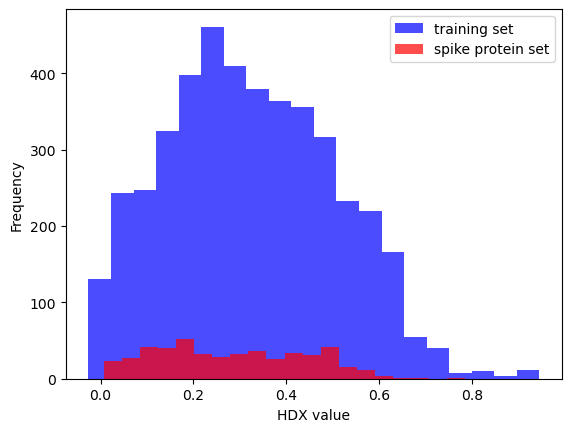

In [39]:
import matplotlib.pyplot as plt

plt.figure()
# plot the bar chart for Y_data and COVID_Y_data
Y_data = np.array(Y_data)
COVID_Y_data = np.array(COVID_Y_data)
#Y_bin = np.digitize(Y_data, [0.2, 0.4, 0.6, 0.8])
#Y_bin = np.append(Y_bin, covid_bin)
#Y_data = np.append(Y_data, COVID_Y_data)
plt.hist(Y_data, bins=20, color='blue', alpha=0.7, label='training set')
plt.hist(COVID_Y_data, bins=20, color='red', alpha=0.7, label='spike protein set')
plt.xlabel('HDX value')
plt.ylabel('Frequency')
plt.legend()
#plt.show()
plt.savefig('/home/lwang/models/HDX_LSTM/data/Fullset/HDX_hist.png')